<a href="https://colab.research.google.com/github/thoid/CFD-with-NN/blob/main/Best_AC_position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import pickle


In [ ]:
from keras.models import load_model

model_S = load_model('/content/Research_Project/Summer/Model/model_summer_N.h5')
with open('/content/Research_Project/Summer/History/history_summer_N.pkl', 'rb') as f:
    history_S = pickle.load(f)

#Sol Air Temperature Calculation

In [ ]:
temp = pd.read_excel('/content/Research_Project/SAT/temp.xlsx')
temp = pd.melt(temp, id_vars=['Jour'], var_name='Heure', value_name='Outdoor Air Temperature')
temp= temp.sort_values(by=['Jour', 'Heure'])

temp

,Jour,Heure,Outdoor Air Temperature
0,1,1,1.3
365,1,2,0.4
730,1,3,0.5
1095,1,4,0.8
1460,1,5,0.3
...,...,...,...
7299,365,20,1.8
7664,365,21,1.1
8029,365,22,1.3
8394,365,23,0.9


In [ ]:
atmo = pd.read_excel('/content/Research_Project/SAT/atmo.xlsx')
atmo = pd.melt(atmo, id_vars=['Jour'], var_name='Heure', value_name='Atmospheric Radiation')
atmo= atmo.sort_values(by=['Jour', 'Heure'])

atmo

,Jour,Heure,Atmospheric Radiation
0,1,1,0.99
365,1,2,0.98
730,1,3,0.98
1095,1,4,0.99
1460,1,5,0.99
...,...,...,...
7299,365,20,1.03
7664,365,21,1.01
8029,365,22,1.00
8394,365,23,0.99


In [ ]:
df_calcul = pd.merge(temp, atmo, on=['Jour', 'Heure'])

df_calcul['Atmospheric Radiation'] = df_calcul['Atmospheric Radiation'].apply(lambda x: x * (10**6/3600))
df_calcul['Ground Surface Longwave Radiation'] = 5.67 * 10**-8 * (df_calcul['Outdoor Air Temperature'] + 273)**4
df_calcul['Effective Longwave Radiation'] =df_calcul['Ground Surface Longwave Radiation'] - df_calcul['Atmospheric Radiation']
df_calcul['Vertical Effective Longwave Radiation'] = 0.5 * df_calcul['Effective Longwave Radiation']
df_calcul['Sol Air Temperature'] = df_calcul['Outdoor Air Temperature'] - 0.77/22.7 * df_calcul['Vertical Effective Longwave Radiation']
df_calcul


,Jour,Heure,Outdoor Air Temperature,Atmospheric Radiation,Ground Surface Longwave Radiation,Effective Longwave Radiation,Vertical Effective Longwave Radiation,Sol Air Temperature
0,1,1,1.3,275.000000,320.986147,45.986147,22.993073,0.520059
1,1,2,0.4,272.222222,316.794111,44.571889,22.285944,-0.355955
2,1,3,0.5,272.222222,317.257854,45.035631,22.517816,-0.263820
3,1,4,0.8,275.000000,318.652136,43.652136,21.826068,0.059644
4,1,5,0.3,275.000000,316.330877,41.330877,20.665439,-0.400986
...,...,...,...,...,...,...,...,...
8755,365,20,1.8,286.111111,323.332956,37.221845,18.610922,1.168704
8756,365,21,1.1,280.555556,320.051009,39.495454,19.747727,0.430143
8757,365,22,1.3,277.777778,320.986147,43.208369,21.604184,0.567171
8758,365,23,0.9,275.000000,319.117917,44.117917,22.058958,0.151745


# Best Configuration

In [ ]:
import numpy as np

index_train = [0,2,3,5,6,7,8,10,11,12,13,15,16,18,19,21,22,24,25,27,28,29,30,32,34,35,36,37,38,39,41,43,44,46,47,48,49,50,53,54,55,56,57,59]

X_tot = np.array([
    [1,26.41,0.10], [1,26.41,8.17],[1,26.41,28.13],
    [1,26.81,0.10], [1,26.81,6.14], [1,26.81,16.12], [1,26.81,36.08],
    [1,27.75,4.90], [1,27.75,24.86], [1,27.75,34.83], [1,27.75,54.79],
    [1,30.33,56.58], [1,30.33,76.53], [1,30.33,86.51], [1,30.33,106.47],

    [2,26.41,0.10], [2,26.41,8.17],[2,26.41,28.13],
    [2,26.81,0.10], [2,26.81,6.14], [2,26.81,16.12], [2,26.81,36.08],
    [2,27.75,4.90], [2,27.75,24.86], [2,27.75,34.83], [2,27.75,54.79],
    [2,30.33,56.58], [2,30.33,76.53], [2,30.33,86.51], [2,30.33,106.47],

    [3,26.41,0.10], [3,26.41,8.17],[3,26.41,28.13],
    [3,26.81,0.10], [3,26.81,6.14], [3,26.81,16.12], [3,26.81,36.08],
    [3,27.75,4.90], [3,27.75,24.86], [3,27.75,34.83], [3,27.75,54.79],
    [2,30.33,56.58], [3,30.33,76.53], [3,30.33,86.51], [3,30.33,106.47],

    [4,26.41,0.10], [4,26.41,8.17],[4,26.41,28.13],
    [4,26.81,0.10], [4,26.81,6.14], [4,26.81,16.12], [4,26.81,36.08],
    [4,27.75,4.90], [4,27.75,24.86], [4,27.75,34.83], [4,27.75,54.79],
    [4,30.33,56.58], [4,30.33,76.53], [4,30.33,86.51], [4,30.33,106.47]
    ])

X_train = np.array([X_tot[i] for i in index_train])

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

scaler =  MinMaxScaler()
scaler.fit(X_train)


MinMaxScaler()

In [ ]:
df = df_calcul[["Jour", "Heure",'Sol Air Temperature']]

df

,Jour,Heure,Sol Air Temperature
0,1,1,0.520059
1,1,2,-0.355955
2,1,3,-0.263820
3,1,4,0.059644
4,1,5,-0.400986
...,...,...,...
8755,365,20,1.168704
8756,365,21,0.430143
8757,365,22,0.567171
8758,365,23,0.151745


In [ ]:
Yac = np.arange(0.4, 4.6, 0.2)
print(Yac)

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8
 4.  4.2 4.4]


In [ ]:
pd.options.mode.copy_on_write = True

for valeur in Yac:
  val = np.round(valeur,3)
  nom_colonne = f"Yac = {val}"
  df[nom_colonne] = 0*df["Sol Air Temperature"]

df

,Jour,Heure,Sol Air Temperature,Yac = 0.4,Yac = 0.6,Yac = 0.8,Yac = 1.0,Yac = 1.2,Yac = 1.4,Yac = 1.6,...,Yac = 2.6,Yac = 2.8,Yac = 3.0,Yac = 3.2,Yac = 3.4,Yac = 3.6,Yac = 3.8,Yac = 4.0,Yac = 4.2,Yac = 4.4
0,1,1,0.520059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,-0.355955,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,1,3,-0.263820,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,1,4,0.059644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,-0.400986,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,365,20,1.168704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,365,21,0.430143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,365,22,0.567171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,365,23,0.151745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Q =  np.arange(0.1, 110, 1)
print(Q)

[1.000e-01 1.100e+00 2.100e+00 3.100e+00 4.100e+00 5.100e+00 6.100e+00
 7.100e+00 8.100e+00 9.100e+00 1.010e+01 1.110e+01 1.210e+01 1.310e+01
 1.410e+01 1.510e+01 1.610e+01 1.710e+01 1.810e+01 1.910e+01 2.010e+01
 2.110e+01 2.210e+01 2.310e+01 2.410e+01 2.510e+01 2.610e+01 2.710e+01
 2.810e+01 2.910e+01 3.010e+01 3.110e+01 3.210e+01 3.310e+01 3.410e+01
 3.510e+01 3.610e+01 3.710e+01 3.810e+01 3.910e+01 4.010e+01 4.110e+01
 4.210e+01 4.310e+01 4.410e+01 4.510e+01 4.610e+01 4.710e+01 4.810e+01
 4.910e+01 5.010e+01 5.110e+01 5.210e+01 5.310e+01 5.410e+01 5.510e+01
 5.610e+01 5.710e+01 5.810e+01 5.910e+01 6.010e+01 6.110e+01 6.210e+01
 6.310e+01 6.410e+01 6.510e+01 6.610e+01 6.710e+01 6.810e+01 6.910e+01
 7.010e+01 7.110e+01 7.210e+01 7.310e+01 7.410e+01 7.510e+01 7.610e+01
 7.710e+01 7.810e+01 7.910e+01 8.010e+01 8.110e+01 8.210e+01 8.310e+01
 8.410e+01 8.510e+01 8.610e+01 8.710e+01 8.810e+01 8.910e+01 9.010e+01
 9.110e+01 9.210e+01 9.310e+01 9.410e+01 9.510e+01 9.610e+01 9.710e+01
 9.810

In [ ]:
df_summer = df_calcul[((df_calcul['Outdoor Air Temperature'] > 27) & (df_calcul['Heure'] > 17))]

df_summer

,Jour,Heure,Outdoor Air Temperature,Atmospheric Radiation,Ground Surface Longwave Radiation,Effective Longwave Radiation,Vertical Effective Longwave Radiation,Sol Air Temperature
4702,196,23,27.3,430.555556,461.109837,30.554282,15.277141,26.781789
4745,198,18,30.7,427.777778,482.349937,54.572160,27.286080,29.774437
4746,198,19,29.9,422.222222,477.287601,55.065379,27.532689,28.966072
4747,198,20,29.3,419.444444,473.517079,54.072634,27.036317,28.382909
4748,198,21,28.5,416.666667,468.524520,51.857854,25.928927,27.620473
4749,198,22,27.2,413.888889,460.495945,46.607056,23.303528,26.409528
4769,199,18,30.8,455.555556,482.985549,27.429994,13.714997,30.334778
4770,199,19,27.7,433.333333,463.571546,30.238213,15.119106,27.187149
4771,199,20,28.0,433.333333,465.424286,32.090953,16.045476,27.455726
4772,199,21,27.6,430.555556,462.955197,32.399642,16.199821,27.050491


In [ ]:
def index_temp(df):
  # Initialisez une liste pour stocker les tuples (index, valeur)
  liste_tuples = []

  # Itérez sur les lignes du DataFrame qui satisfont la condition
  for index, row in df.iterrows():
      # Récupérez l'index et la valeur de la colonne 'Sol Air Temperature'
      index_ligne = index
      valeur_colonne = row['Sol Air Temperature']

      # Ajoutez le tuple à la liste
      liste_tuples.append((index_ligne, valeur_colonne))

  # Affichez la liste de tuples
  return liste_tuples

index_temp_summer = index_temp(df_summer)

print(index_temp_summer)

[(4702, 26.78178861091349), (4745, 29.77443693902857), (4746, 28.96607177271744), (4747, 28.382909067449358), (4748, 27.62047252441321), (4749, 26.40952789847683), (4769, 30.33477764026222), (4770, 27.18714925362863), (4771, 27.455726131546424), (4772, 27.050490659605874), (4793, 29.02299096052469), (4794, 28.03013433066387), (4795, 26.41415350685522), (4865, 28.039709499451874), (4866, 26.555489777046116), (4868, 27.592342946451094), (4869, 27.68183720914806), (4870, 26.828900700977123), (4889, 27.512245773540503), (4890, 26.791050227364277), (4937, 27.455726131546424), (4961, 27.451006676260196), (5273, 27.808920884667735), (5274, 27.540500938957162), (5275, 27.31438986135553), (5276, 26.998700893374103), (5277, 26.593340250658965), (5297, 26.824254286281057), (5633, 26.579369758969555), (5753, 26.777142196217426), (5825, 26.913821638156612)]


In [ ]:
for i in range(len(index_temp_summer)):

  index = index_temp_summer[i][0]
  SAT = index_temp_summer[i][1]
  S = 0
  for j in range(len(Q)):

    X = []

    if S == len(Yac):
      break

    else:
      for k in range(len(Yac)):
        X.append(np.array([Yac[k], SAT, Q[j]]))
      X = scaler.transform(X)
      y_result = model_S.predict(np.array(X))
      for z in range(len(y_result)):
        if df.iloc[index, z+3] ==0 :
          if np.mean(y_result[z])<0.5:
            df.iloc[index, z+3] = Q[j]
            S+=1





1/1 [==============================] - 0s 16ms/step


In [ ]:
df1 = df[df['Yac = 0.4' ]> 0]

sum_values = df1.iloc[:, 3:].sum(axis=0)
df1.loc[len(df1)] = ['Sum',np.nan,np.nan] + list(sum_values)

In [ ]:
df1

,Jour,Heure,Sol Air Temperature,Yac = 0.4,Yac = 0.6,Yac = 0.8,Yac = 1.0,Yac = 1.2,Yac = 1.4,Yac = 1.6,...,Yac = 2.6,Yac = 2.8,Yac = 3.0,Yac = 3.2,Yac = 3.4,Yac = 3.6,Yac = 3.8,Yac = 4.0,Yac = 4.2,Yac = 4.4
4702,196,23,26.781789,22.1,23.1,23.1,24.1,24.1,24.1,25.1,...,25.1,25.1,24.1,25.1,26.1,27.1,28.1,28.1,29.1,30.1
4745,198,18,29.774437,57.1,58.1,58.1,59.1,59.1,60.1,61.1,...,60.1,60.1,60.1,60.1,61.1,62.1,63.1,64.1,65.1,65.1
4746,198,19,28.966072,47.1,48.1,48.1,49.1,50.1,51.1,52.1,...,49.1,48.1,48.1,49.1,50.1,51.1,52.1,53.1,54.1,55.1
4747,198,20,28.382909,40.1,41.1,42.1,42.1,43.1,44.1,45.1,...,43.1,41.1,40.1,42.1,43.1,45.1,46.1,48.1,49.1,50.1
4748,198,21,27.620473,29.1,30.1,32.1,33.1,34.1,35.1,37.1,...,36.1,34.1,33.1,35.1,36.1,37.1,39.1,40.1,40.1,41.1
4749,198,22,26.409528,20.1,21.1,22.1,22.1,22.1,21.1,21.1,...,21.1,21.1,20.1,21.1,21.1,22.1,23.1,23.1,24.1,25.1
4769,199,18,30.334778,64.1,65.1,65.1,66.1,66.1,67.1,67.1,...,67.1,68.1,68.1,69.1,70.1,70.1,71.1,72.1,73.1,74.1
4770,199,19,27.187149,25.1,25.1,26.1,27.1,28.1,29.1,30.1,...,31.1,30.1,29.1,30.1,31.1,32.1,33.1,34.1,35.1,35.1
4771,199,20,27.455726,27.1,28.1,29.1,30.1,31.1,33.1,34.1,...,34.1,33.1,32.1,33.1,34.1,35.1,36.1,37.1,38.1,39.1
4772,199,21,27.050491,24.1,24.1,25.1,26.1,27.1,27.1,28.1,...,29.1,28.1,28.1,28.1,29.1,30.1,31.1,32.1,33.1,34.1


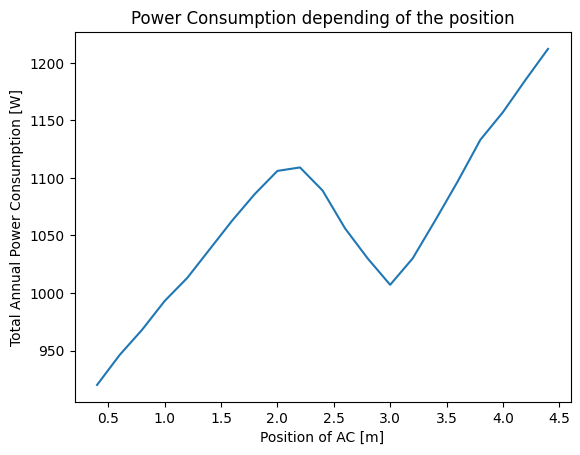

In [ ]:
power = df1.iloc[-1, 3:].tolist()

plt.plot(Yac, power)

plt.xlabel('Position of AC [m]')
plt.ylabel('Total Annual Power Consumption [W]')
plt.title('Power Consumption depending of the position')

plt.show()

In [ ]:
min_power = min(power)
max_power = max(power)

index_min_power = power.index(min_power)
index_max_power = power.index(max_power)

position_min_power = Yac[index_min_power]
position_max_power = Yac[index_max_power]

print("La valeur minimale de la liste power est :", np.round(min_power,3))
print("La valeur de l'abscisse correspondante est :", np.round(position_min_power,3))
print("La valeur maximale de la liste power est :", np.round(max_power,3))
print("La valeur de l'abscisse correspondante est :", np.round(position_max_power,3))

La valeur minimale de la liste power est : 920.1
La valeur de l'abscisse correspondante est : 0.4
La valeur maximale de la liste power est : 1212.1
La valeur de l'abscisse correspondante est : 4.4


In [ ]:
percent = (max_power - min_power)/max_power*100

print('Economy :', percent,'%')

Economy : 24.090421582377637 %
